# Base Model Componenets


## Imports

In [59]:
!pip install torchvision
from torchvision import datasets
from torchvision import transforms
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchvision.utils import save_image

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics.cluster import normalized_mutual_info_score

## Function to show images



In [60]:
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')


## Function to regenerate an image from a given image

In [61]:
def plot_reconstruction(model, n=24):
    x,_ = next(iter(data_loader))
    x = x[:n,:,:,:].to(device)
    try:
        out, _, _, log_p = model(x.view(-1, image_size))
    except:
        out, _, _ = model(x.view(-1, image_size))
    x_concat = torch.cat([x.view(-1, 1, 28, 28), out.view(-1, 1, 28, 28)], dim=3)
    out_grid = torchvision.utils.make_grid(x_concat).cpu().data
    show(out_grid)


## Function to generate an image from an arbitary distribution.

In [62]:
def plot_generation(model, n=24):
    with torch.no_grad():
        z = torch.randn(n, z_dim).to(device)
        out = model.decode(z).view(-1, 1, 28, 28)

    out_grid = torchvision.utils.make_grid(out).cpu()
    show(out_grid)

## Configuretions



In [63]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create a directory if not exists
sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

## Dataset Loading

In [64]:
# Specify data directory
data_dir = 'data'

# Fashion-MNIST dataset
dataset  = datasets.FashionMNIST(root=data_dir, train=True, download=True,
                                  transform=transforms.ToTensor())

test_dataset = datasets.FashionMNIST(root=data_dir, train=False, download=True,
                                  transform=transforms.ToTensor())

# Data loaders (adjust batch size as needed)
data_loader  = torch.utils.data.DataLoader(dataset=dataset , batch_size=128, shuffle=True)
test_loader  = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=10, shuffle=False)

# Now you have access to the Fashion-MNIST dataset through train_loader and test_loader

## VAE Architecture

In [65]:

# VAE model
class VAE_3(nn.Module):
    def __init__(self, image_size=784, h_dim=400, z_dim=20):
        super(VAE_3, self).__init__()
        self.fc1 = nn.Linear(image_size, h_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(h_dim, z_dim)
        self.fc4 = nn.Linear(z_dim, h_dim)
        self.fc5 = nn.Linear(h_dim, image_size)

    def encode(self, x):
        h = F.relu(self.fc1(x))
        return self.fc2(h), self.fc3(h)

    def reparameterize(self, mu, log_var):
        std = torch.exp(log_var/2)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.relu(self.fc4(z))
        return torch.sigmoid(self.fc5(h))

    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        x_reconst = self.decode(z)
        return x_reconst, mu, log_var


## Create VAE model

In [66]:
# Hyper-parameters
image_size = 784
h_dim = 400
z_dim = 20
num_epochs = 15
learning_rate = 1e-3

model_3 = VAE_3().to(device)
optimizer = torch.optim.Adam(model_3.parameters(), lr=learning_rate)

## Train the model

In [67]:
final_losses_3 = []
# Start training
for epoch in range(num_epochs):
    
    epoch_loss = 0.0
    for i, (x, _) in enumerate(data_loader):
        # Forward pass
        x = x.to(device).view(-1, image_size)
        x_reconst, mu, log_var = model_3(x)

        # Compute reconstruction loss and kl divergence
        # For KL divergence between Gaussians, see Appendix B in VAE paper or (Doersch, 2016):
        # https://arxiv.org/abs/1606.05908
        reconst_loss = F.binary_cross_entropy(x_reconst, x, reduction='sum')
        kl_div = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

        # Backprop and optimize
        loss = reconst_loss + kl_div
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()

        if (i+1) % 10 == 0:
            print ("Epoch[{}/{}], Step [{}/{}], Reconst Loss: {:.4f}, KL Div: {:.4f}"
                   .format(epoch+1, num_epochs, i+1, len(data_loader), reconst_loss.item()/len(x), kl_div.item()/len(x)))
    
    final_losses_3.append(epoch_loss / len(data_loader.dataset))

Epoch[1/15], Step [10/469], Reconst Loss: 418.7299, KL Div: 8.6778
Epoch[1/15], Step [20/469], Reconst Loss: 372.5063, KL Div: 9.4286
Epoch[1/15], Step [30/469], Reconst Loss: 326.1015, KL Div: 11.6381
Epoch[1/15], Step [40/469], Reconst Loss: 318.5031, KL Div: 13.1224
Epoch[1/15], Step [50/469], Reconst Loss: 301.4342, KL Div: 11.4916
Epoch[1/15], Step [60/469], Reconst Loss: 272.5171, KL Div: 12.9387
Epoch[1/15], Step [70/469], Reconst Loss: 291.5905, KL Div: 12.6983
Epoch[1/15], Step [80/469], Reconst Loss: 281.1718, KL Div: 13.9945
Epoch[1/15], Step [90/469], Reconst Loss: 268.2065, KL Div: 13.1463
Epoch[1/15], Step [100/469], Reconst Loss: 260.5569, KL Div: 14.9555
Epoch[1/15], Step [110/469], Reconst Loss: 280.7444, KL Div: 14.2688
Epoch[1/15], Step [120/469], Reconst Loss: 267.4235, KL Div: 13.0134
Epoch[1/15], Step [130/469], Reconst Loss: 285.0542, KL Div: 15.2495
Epoch[1/15], Step [140/469], Reconst Loss: 282.7457, KL Div: 14.1599
Epoch[1/15], Step [150/469], Reconst Loss: 25

## Show generation

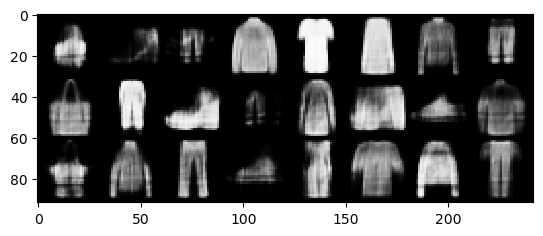

In [68]:
plot_generation(model_3)

## Show Reconstraction

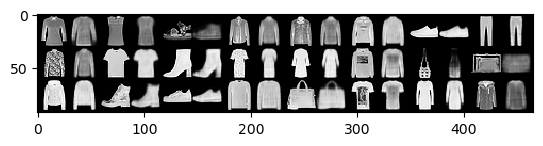

In [69]:
plot_reconstruction(model_3)

# Tasks

## a.
### Change the base three layer model into a four layer model

In this task you need to modify the VAE class and convert it into a four layer class

In [70]:
# Change the VAE class
import torch
from torch import nn
from torch.nn import functional as F

class VAE4Layer(nn.Module):
    def __init__(self, image_size=784, h_dim=400, z_dim=20, intermediate_dim=256):
        super(VAE4Layer, self).__init__()
        # Encoder
        self.fc1 = nn.Linear(image_size, h_dim)
        self.fc_intermediate_e = nn.Linear(h_dim, intermediate_dim)  # Additional intermediate layer in encoder
        self.fc2 = nn.Linear(intermediate_dim, z_dim)  # Maps intermediate representation to mean of latent space
        self.fc3 = nn.Linear(intermediate_dim, z_dim)  # Maps intermediate representation to log-variance of latent space

        # Decoder
        self.fc4 = nn.Linear(z_dim, intermediate_dim)  # Additional intermediate layer in decoder
        self.fc_intermediate_d = nn.Linear(intermediate_dim, h_dim)  # Maps back to h_dim
        self.fc5 = nn.Linear(h_dim, image_size)

    def encode(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc_intermediate_e(h))  # Pass through the additional intermediate layer
        return self.fc2(h), self.fc3(h)

    def reparameterize(self, mu, log_var):
        std = torch.exp(log_var / 2)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.relu(self.fc4(z))
        h = F.relu(self.fc_intermediate_d(h))  # Pass through the additional intermediate layer
        return torch.sigmoid(self.fc5(h))

    def forward(self, x):
        mu, log_var = self.encode(x.view(-1, image_size))  # Ensure x is flattened if necessary
        z = self.reparameterize(mu, log_var)
        x_reconst = self.decode(z)
        return x_reconst, mu, log_var


In [71]:
# Create new model

# Hyper-parameters
image_size = 784
h_dim = 400
z_dim = 20
intermediate_dim = 784
num_epochs = 15
learning_rate = 1e-3

model_4 = VAE().to(device)
optimizer = torch.optim.Adam(model_4.parameters(), lr=learning_rate)

In [80]:
# Train new model
# Start training
final_losses_4 = []
bad_image_original = None
bad_image_reconst = None
best_image_original = None
best_image_reconst = None

reconst_min = None
reconst_max = None

for epoch in range(num_epochs):
    
    epoch_loss = 0.0
    
    for i, (x, _) in enumerate(data_loader):
        # Forward pass
        x = x.to(device).view(-1, image_size)
        x_reconst, mu, log_var = model_4(x)

        # Compute reconstruction loss and kl divergence
        # For KL divergence between Gaussians, see Appendix B in VAE paper or (Doersch, 2016):
        # https://arxiv.org/abs/1606.05908
        reconst_loss = F.binary_cross_entropy(x_reconst, x, reduction='sum')
        kl_div = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

        if(reconst_min == None):
            reconst_min = reconst_loss.item()/len(x)
            reconst_max = reconst_loss.item()/len(x)
            bad_image_original = x
            bad_image_reconst = x_reconst
            best_image_original = x
            best_image_reconst = x_reconst
        elif(reconst_loss.item()/len(x) > reconst_max):
            reconst_max = reconst_loss.item()/len(x)
            best_image_original = x
            best_image_reconst = x_reconst
        elif(reconst_loss.item()/len(x) > reconst_min):
            reconst_min = reconst_loss.item()/len(x)
            bad_image_original = x
            bad_image_reconst = x_reconst

        
        # Backprop and optimize
        loss = reconst_loss + kl_div
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()

        if (i+1) % 10 == 0:
            print ("Epoch[{}/{}], Step [{}/{}], Reconst Loss: {:.4f}, KL Div: {:.4f}"
                   .format(epoch+1, num_epochs, i+1, len(data_loader), reconst_loss.item()/len(x), kl_div.item()/len(x)))
    
    final_losses_4.append(epoch_loss / len(data_loader.dataset))
print(reconst_min)
print(reconst_max)

Epoch[1/15], Step [10/469], Reconst Loss: 230.5695, KL Div: 17.5783
Epoch[1/15], Step [20/469], Reconst Loss: 221.4526, KL Div: 15.7032
Epoch[1/15], Step [30/469], Reconst Loss: 223.1613, KL Div: 16.1487
Epoch[1/15], Step [40/469], Reconst Loss: 218.2321, KL Div: 16.8882
Epoch[1/15], Step [50/469], Reconst Loss: 227.4754, KL Div: 15.9853
Epoch[1/15], Step [60/469], Reconst Loss: 222.1063, KL Div: 16.0657
Epoch[1/15], Step [70/469], Reconst Loss: 217.8231, KL Div: 15.4550
Epoch[1/15], Step [80/469], Reconst Loss: 221.5213, KL Div: 15.7660
Epoch[1/15], Step [90/469], Reconst Loss: 215.5125, KL Div: 16.2023
Epoch[1/15], Step [100/469], Reconst Loss: 228.0353, KL Div: 16.5676
Epoch[1/15], Step [110/469], Reconst Loss: 215.9396, KL Div: 16.1539
Epoch[1/15], Step [120/469], Reconst Loss: 237.0366, KL Div: 15.8930
Epoch[1/15], Step [130/469], Reconst Loss: 218.1849, KL Div: 15.7362
Epoch[1/15], Step [140/469], Reconst Loss: 222.6957, KL Div: 16.1252
Epoch[1/15], Step [150/469], Reconst Loss: 

KeyboardInterrupt: 

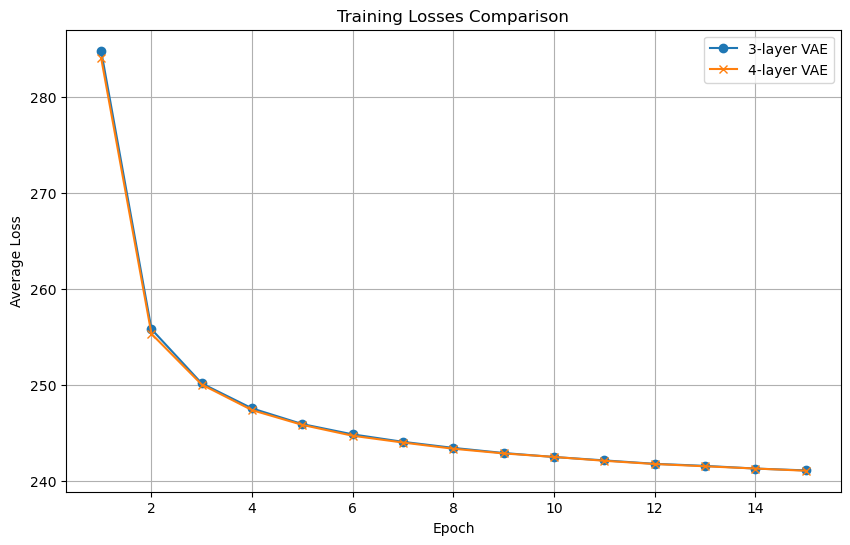

In [73]:
# Compare the final loss of the fully trained old model and the new model
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, final_losses_3, label='3-layer VAE', marker='o')
plt.plot(epochs, final_losses_4, label='4-layer VAE', marker='x')

plt.title('Training Losses Comparison')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.legend()
plt.grid(True)
plt.show()



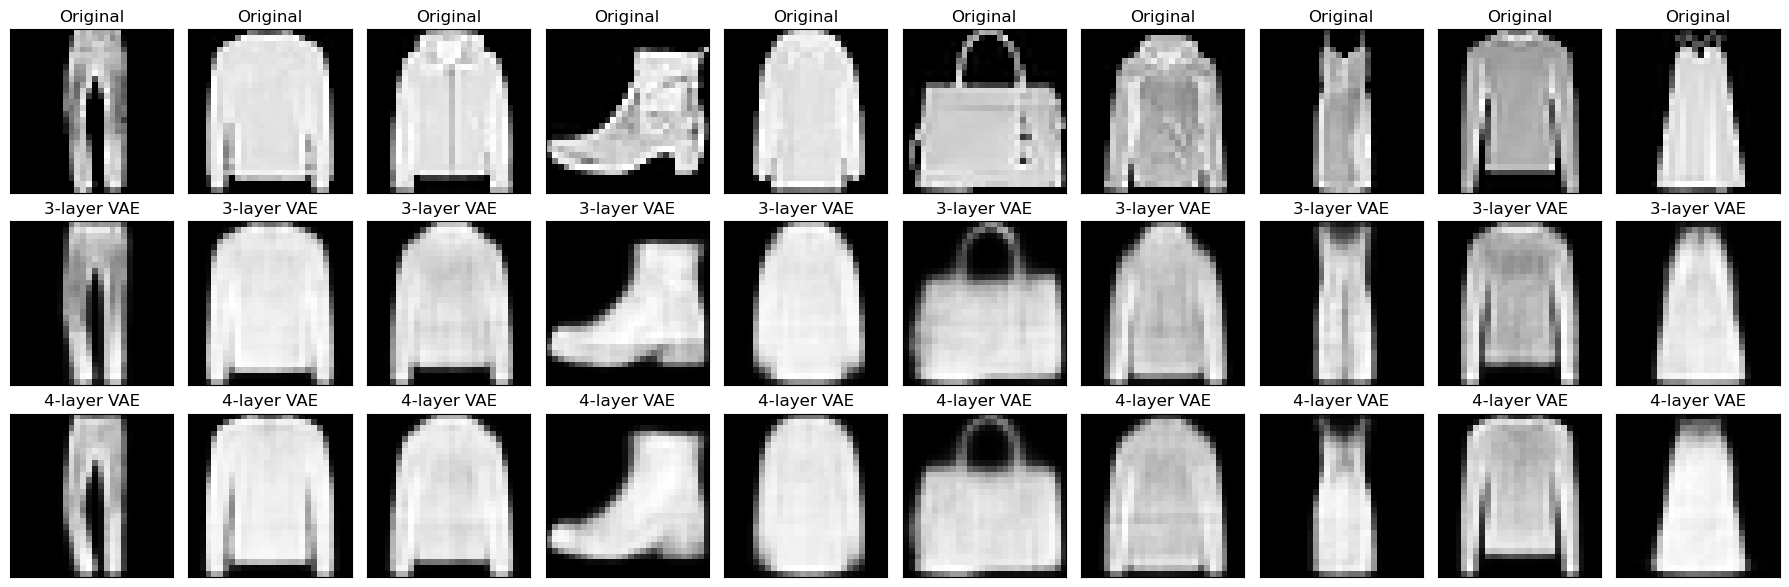

In [76]:
# Compare the reconstructed images from the two models
#bad_image_original = None
#bad_image_reconst = None
#best_image_original = None
#best_image_reconst = None

#reconst_min = None
#reconst_max = None
reconst_image_3_layer, _, _ = model_3(best_image_original)
reconst_image_4_layer, _, _ = model_4(best_image_original)

reconst3 = reconst_image_3_layer.detach();
reconst4 = reconst_image_4_layer.detach();

import matplotlib.pyplot as plt

def plot_comparison(best_image_original, reconst_images_3_layer, reconst_images_4_layer, n=10):
    plt.figure(figsize=(18, 6))
    
    for i in range(n):
        # Display original
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(best_image_original[i].reshape(28, 28).cpu().numpy(), cmap='gray')
        plt.title("Original")
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Display reconstruction from 3-layer VAE
        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(reconst3[i].reshape(28, 28).cpu().numpy(), cmap='gray')
        plt.title("3-layer VAE")
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Display reconstruction from 4-layer VAE
        ax = plt.subplot(3, n, i + 1 + n * 2)
        plt.imshow(reconst4[i].reshape(28, 28).cpu().numpy(), cmap='gray')
        plt.title("4-layer VAE")
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.tight_layout()
    plt.show()

# Assuming x_test is preprocessed appropriately for your model
# (e.g., flattened, normalized, etc., as necessary)
plot_comparison(best_image_original, reconst3, reconst4)


In [ ]:
# Compare generate images from the two models

## b.
### Change the layers

In this experiment you will change the layers of the VAE using different combinations and compare the results

In [ ]:
# Create different 3 layer VAE models with different h-dim and z-dim

In [ ]:
# Train all models

In [ ]:
# Compare the models based on their optimal loss

In [ ]:
# Compare models based on their generated images (visual inspection)

In [ ]:
# Compare models based on their regenerated images (visual inspection)

## c.
### Create a Normal Autoencoder

In this experiment you will convert the current model into an autoencoder

In [ ]:
# Convert the VAE class into an 3layer autoencoder

In [ ]:
# Create the autoenocder model

In [ ]:
# Change the training procedure to train the auto-enocder

In [ ]:
# Compare the models based on their optimal loss

In [ ]:
# Compare models based on their generated images (visual inspection)

In [ ]:
# Compare models based on their regenerated images (visual inspection)

## References
1. https://github.com/dataflowr/notebooks/blob/master/HW3/VAE_clustering_empty.ipynb